# Wilcoxon Signed Rank Test

The Wilcoxon signed rank test (also called the Wilcoxon signed rank sum test) is a non-parametric test to compare data. The Wilcoxon signed rank test should be used if the differences between pairs of data are non-normally distributed. The Wilcoxon matched-pairs signed rank test computes the difference between each set of matched pairs, then follows the same procedure as the signed rank test to compare the sample against some median. [Source](https://www.statisticshowto.com/wilcoxon-signed-rank-test/#:~:text=The%20Wilcoxon%20signed%20rank%20test%20compares%20your%20sample%20median%20against,the%20sample%20against%20some%20median.)

In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy
from scipy.stats import wilcoxon
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format


### Try Wilcoxon

In [2]:
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75]
scipy.stats.wilcoxon(d)


WilcoxonResult(statistic=0.0, pvalue=0.000244140625)

In [3]:
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75]
scipy.stats.wilcoxon(d, alternative='greater')

WilcoxonResult(statistic=91.0, pvalue=0.0001220703125)

In [4]:
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, 49, 56, 60, 75]
scipy.stats.wilcoxon(d, alternative='less')

WilcoxonResult(statistic=91.0, pvalue=1.0)

### Define some variables

In [5]:
asrs = ["quartznet", "hubert", "wav2vec-base"]
datasets = ["YBAA", "ZHAA", "ASI", "TNI", "NCC",
            "TXHC", "EBVS", "ERMS", "YDCK", "YKWK", "THV", "TLV"]

In [6]:
RANDOM = "Random"

# tool_short_names = [RANDOM, "Triphone", "Phoneme", "PEP", "PEP-D", "SEP", "WEP", "WEP-D"]
# error_model_tool_names = ["random", "error_model_triphone_rich", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
#                           "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance", "word_error_predictor_real/word_enhance"]
# finetuned_model_tool_names = ["random", "triphone_rich", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
#                               "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance", "word_error_real_mix/word_enhance"]


tool_short_names = [RANDOM, "Phoneme-Rich", "PEP", "PEP-D", "CrossASR", "ASRDebugger"]
error_model_tool_names = ["random", "error_model_pure_diversity", "error_model_without_diversity_enhancing", "error_model",
                          "asrevolve_error_model_real", "word_error_predictor_real/no_word_enhance"]
finetuned_model_tool_names = ["random", "pure_diversity", "icassp_without_diversity_enhancing_real_mix", "icassp_real_mix",
                              "asrevolve_error_model_real", "word_error_real_mix/no_word_enhance"]

shorten_error_model_name = {}
for i in range(len(error_model_tool_names)):
    shorten_error_model_name[error_model_tool_names[i]] = tool_short_names[i]

shorten_finetuned_model_name = {}
for i in range(len(finetuned_model_tool_names)):
    shorten_finetuned_model_name[finetuned_model_tool_names[i]] = tool_short_names[i]


def shorten_em_name(tools):
    return [shorten_error_model_name[tool] for tool in tools]


def shorten_ft_name(tools):
    return [shorten_finetuned_model_name[tool] for tool in tools]


## Analyze RQ1

In [7]:
with open('result/RQ1.json', 'r') as f:
  data = json.load(f)


In [8]:
res = {}
for asr in asrs:
    res[asr] = {}
    for dataset in datasets:
        res[asr][dataset] = {}
        for tool, tool_short_name in shorten_error_model_name.items():
            res[asr][dataset][tool_short_name] = pd.read_csv(data[asr][dataset][tool])
            
# res


In [9]:
def get_wer_result(df):
    arr = list(df["WER_Seed1"]) + list(df["WER_Seed2"]) + list(df["WER_Seed3"])
    assert len(arr) == 3 * len(df["WER_Seed1"])
    assert len(arr) == 3 * len(df["WER_Seed2"])
    assert len(arr) == 3 * len(df["WER_Seed3"])
    return arr

#### Measure Relative Improvement

In [10]:
relative_improvement = {}
for asr in asrs :
    relative_improvement[asr] = {}
    for dataset in datasets :
        relative_improvement[asr][dataset] = {}
        wers_rnd = get_wer_result(res[asr][dataset][RANDOM])
        for tool in tool_short_names :
            if tool != RANDOM:
                wers = get_wer_result(res[asr][dataset][tool])
                relative_improvement[asr][dataset][tool] = list(100 * np.subtract(wers, wers_rnd) / wers_rnd)

# relative_improvement


In [11]:
## average realtive improvement
average_relative_improvement = {}
for asr in asrs:
    average_relative_improvement[asr] = {}
    for dataset in datasets:
        average_relative_improvement[asr][dataset] = {}
        for tool in tool_short_names:
            if tool != RANDOM:
                average_relative_improvement[asr][dataset][tool] = np.mean(relative_improvement[asr][dataset][tool])
    
average_relative_improvement["quartznet"]


{'YBAA': {'Phoneme-Rich': -3.4602645437030866,
  'PEP': 10.227987952555916,
  'PEP-D': 9.02195067678909,
  'CrossASR': 6.674390756340277,
  'ASRDebugger': 27.384965054898412},
 'ZHAA': {'Phoneme-Rich': -1.1567549104702266,
  'PEP': 4.583013498471619,
  'PEP-D': 4.536193932253801,
  'CrossASR': 7.839002568016791,
  'ASRDebugger': 21.849795578558624},
 'ASI': {'Phoneme-Rich': 2.5389706189014096,
  'PEP': 6.161863298670234,
  'PEP-D': 2.830868879134769,
  'CrossASR': 12.76265295564401,
  'ASRDebugger': 21.424847109487157},
 'TNI': {'Phoneme-Rich': 5.1965783580760325,
  'PEP': 5.943092614655566,
  'PEP-D': 6.450724402361356,
  'CrossASR': 10.196259945909249,
  'ASRDebugger': 27.039425993082247},
 'NCC': {'Phoneme-Rich': 2.401490901764587,
  'PEP': 10.041951266701231,
  'PEP-D': 10.764512336275544,
  'CrossASR': 7.5112727466405245,
  'ASRDebugger': 20.315882758849767},
 'TXHC': {'Phoneme-Rich': -6.546456284524445,
  'PEP': 4.406699438645446,
  'PEP-D': 4.812964688675949,
  'CrossASR': 4.163

In [12]:
df = pd.DataFrame(average_relative_improvement["quartznet"])
df = df.T
df


,Phoneme-Rich,PEP,PEP-D,CrossASR,ASRDebugger
YBAA,-3.460,10.228,9.022,6.674,27.385
ZHAA,-1.157,4.583,4.536,7.839,21.850
ASI,2.539,6.162,2.831,12.763,21.425
TNI,5.197,5.943,6.451,10.196,27.039
NCC,2.401,10.042,10.765,7.511,20.316
TXHC,-6.546,4.407,4.813,4.164,16.088
EBVS,2.417,5.107,4.229,-1.144,15.147
ERMS,0.466,9.190,11.631,4.260,23.357
YDCK,2.938,8.784,9.608,10.561,28.368
YKWK,5.544,11.583,10.213,14.497,27.872


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import figure

# https://matplotlib.org/stable/api/markers_api.html
method_marker = {
    "Phoneme-Rich": "s",
    "PEP": "o",
    "PEP-D": "^",
    "CrossASR": "p",
    "ASRDebugger": "*"
}

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
method_color = {
    "Phoneme-Rich": "k",
    "PEP": "g",
    "PEP-D": "c",
    "CrossASR": "m",
    "ASRDebugger": "b"
}

rcParams['font.family'] = 'Times New Roman'
rcParams['font.sans-serif'] = ['Times New Roman']

def plot_figure_average_improvement(id:str, title_name:str, filename:str, y_label_name=None):
    df = pd.DataFrame(average_relative_improvement[id])
    df = df.T

    figure(figsize=(14, 12), dpi=600) # increase dpi when saving the image

    for method in tool_short_names:
        markersize = 28
        if method == "WEP": markersize = 32
        if method == "CrossASR": markersize = 32
        if method == "ASRDebugger": markersize = 35
        if method != RANDOM : plt.plot(df[method], label=method, color=method_color[method], marker=method_marker[method], lw=3.0, markersize=markersize)
        # if method != RANDOM : plt.plot(df[method], color=method_color[method], marker=method_marker[method], lw=3.0, markersize=markersize)

    # plt.legend(loc='upper left', fontsize=20)

    # plt.title('{}'.format(title_name), size=38, fontweight='bold')
    if y_label_name : plt.ylabel(y_label_name, size=36, fontweight='bold')
    x_label_name = 'Dataset'
    plt.xlabel(x_label_name, size=36, fontweight='bold')
    plt.yticks(fontsize=32, fontweight='bold')
    if id == "quartznet" : plt.yticks(np.arange(-10, 30, 5), fontsize=32, fontweight='bold')
    if id == "hubert": plt.yticks(np.arange(-10, 45, 5), fontsize=32, fontweight='bold')
    if id == "wav2vec-base": plt.yticks(np.arange(-10, 40, 5), fontsize=32, fontweight='bold')
    plt.xticks(fontsize=32, fontweight='bold', rotation=45)
    plt.grid(b=True, axis='both', linewidth=0.8)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

y_label_name = "Average Improvement (%)"

fname_template = "result/plot/average_improvement/{}.pdf"
os.makedirs(os.path.dirname(fname_template), exist_ok=True)
plot_figure_average_improvement("quartznet", "QuartzNet", filename=fname_template.format("quartznet"), y_label_name=y_label_name)
plot_figure_average_improvement("hubert", "HuBERT", filename=fname_template.format("hubert"), y_label_name=None)
plot_figure_average_improvement("wav2vec-base", "wav2vec 2.0", filename=fname_template.format("wav2vec-base"), y_label_name=None)


#### 1.1. Analyze the experiment without grouping

In [ ]:
def plot_heatmap(metrics, title, cmap, fpath, vmin, vmax, annot=True):

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(12, 9))
    fig = sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax,
                      annot=annot, fmt="d", linewidth=0.7)
    plt.title(title, fontsize=24)
    plt.xlabel('Tool', fontsize=16)
    plt.ylabel('Tool', fontsize=16)
    fig.figure.savefig(fpath, bbox_inches='tight')
    plt.show()


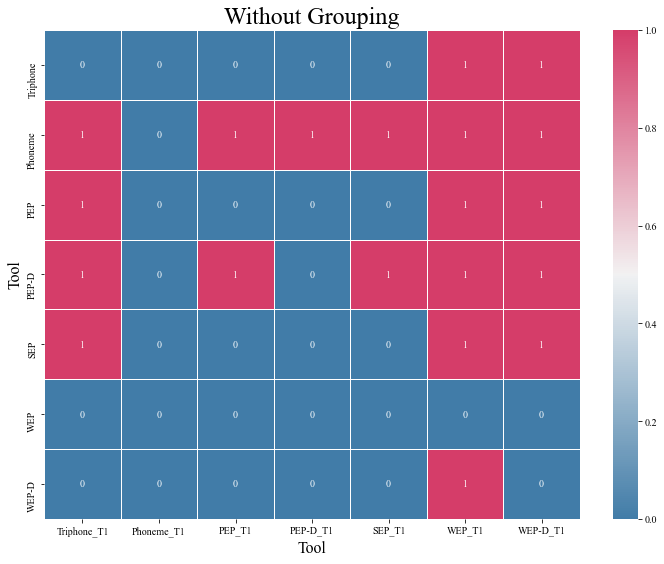

In [ ]:
values = {}

tool_short_names.remove(RANDOM)

for tool_1 in tool_short_names:
    values[tool_1+"_T1"] = {}
    for tool_2 in tool_short_names:

        if tool_1 == tool_2:
            values[tool_1+"_T1"][tool_2] = 0
        else :
            arr_1 = []
            arr_2 = []
            for asr in asrs:
                for dataset in datasets :
                    arr_1 += relative_improvement[asr][dataset][tool_1]
                    arr_2 += relative_improvement[asr][dataset][tool_2]

            w, p = scipy.stats.wilcoxon(
                arr_1, arr_2, alternative='greater')
            # we would reject the null hypothesis at a confidence level of 5%
            if p < 0.05:
                values[tool_1+"_T1"][tool_2] = 1
            else :
                values[tool_1+"_T1"][tool_2] = 0

tool_short_names.append(RANDOM)

df = pd.DataFrame(data=values)

fpath = f"result/plot/RQ1/significance_difference_without_grouping.png"
os.makedirs(os.path.dirname(fpath), exist_ok=True)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0, s=75, l=50, n=1, as_cmap=True)
plot_heatmap(df, "Without Grouping", cmap, fpath, 0, 1)
            


#### 1.2. Analyze the experiment grouped by \<Dataset\>

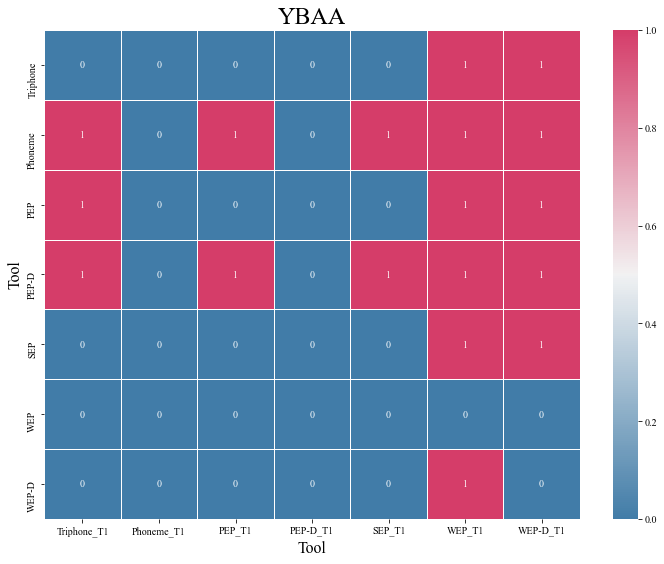

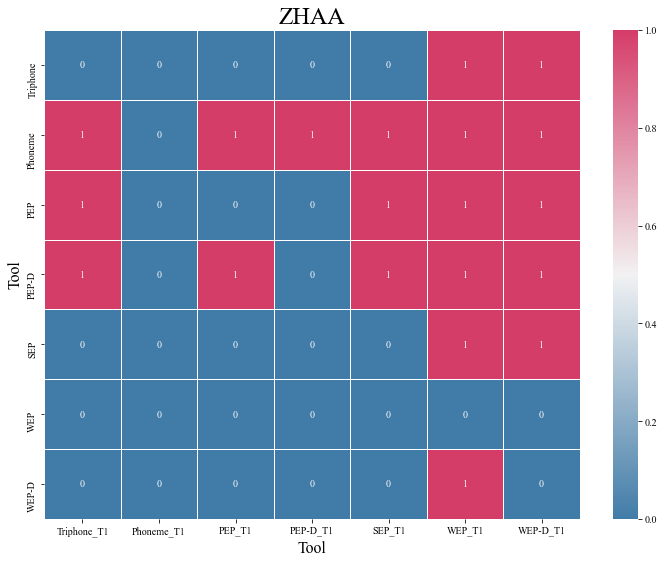

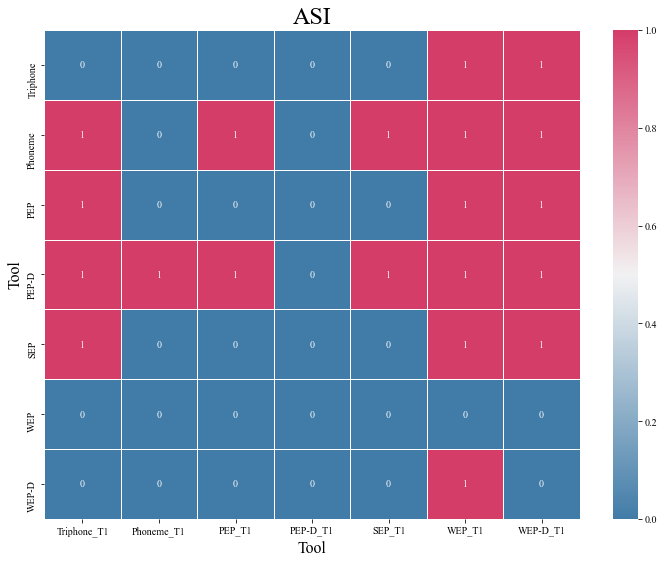

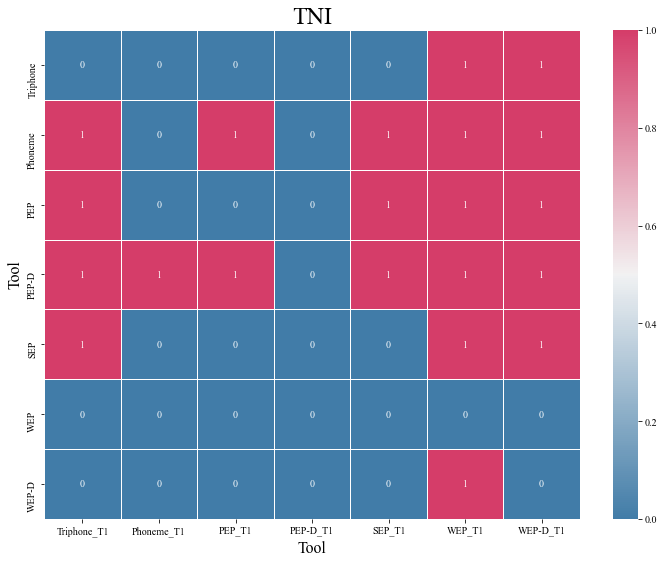

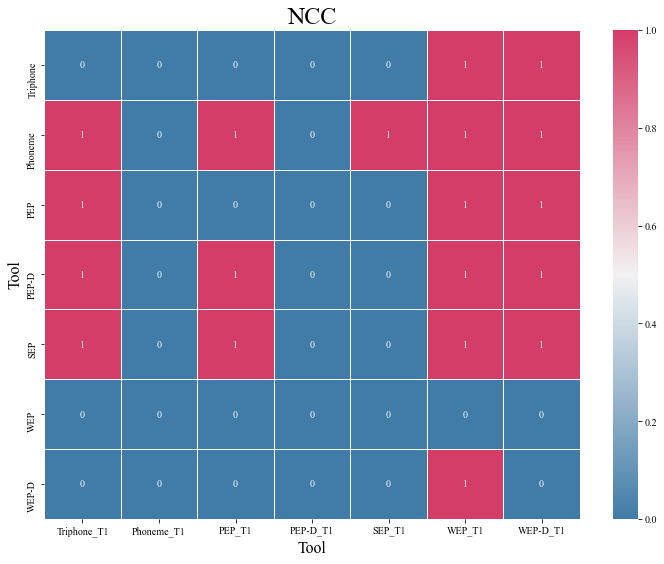

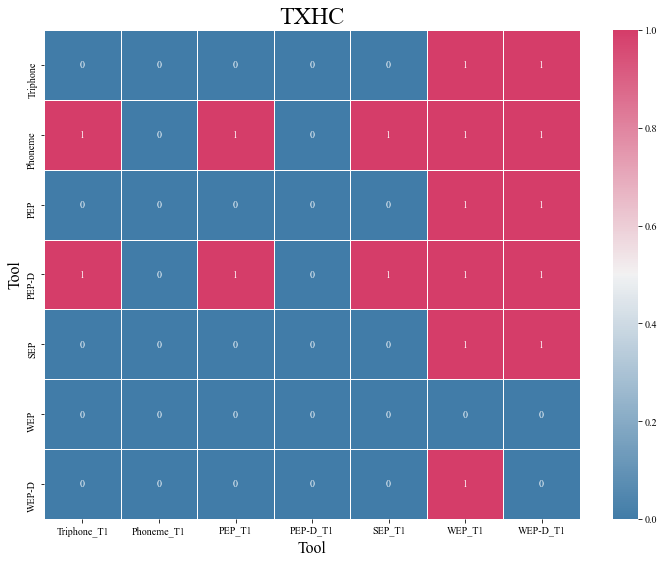

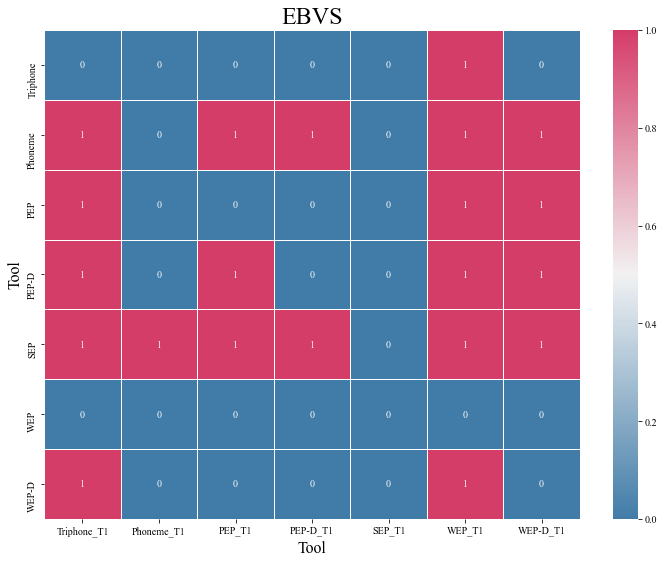

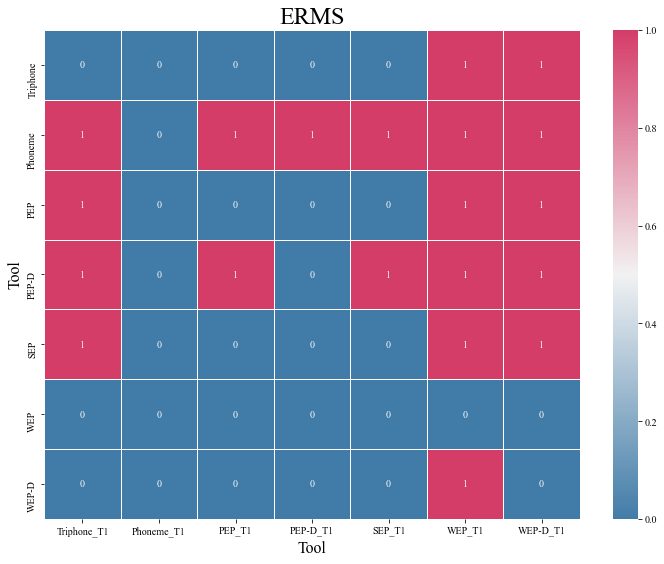

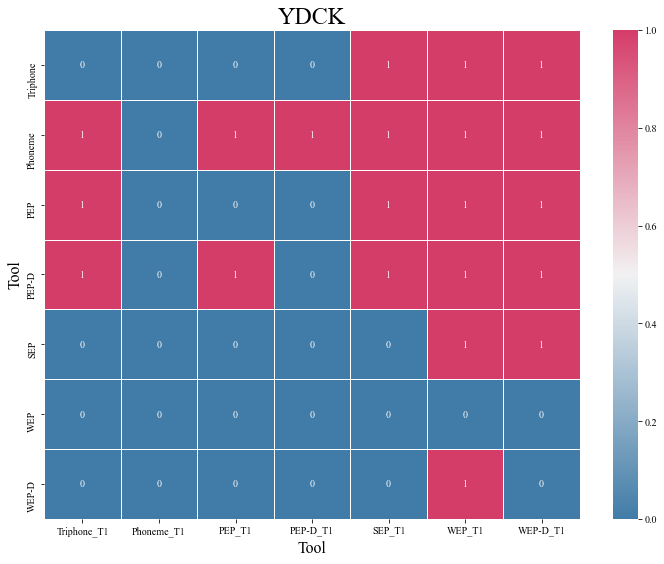

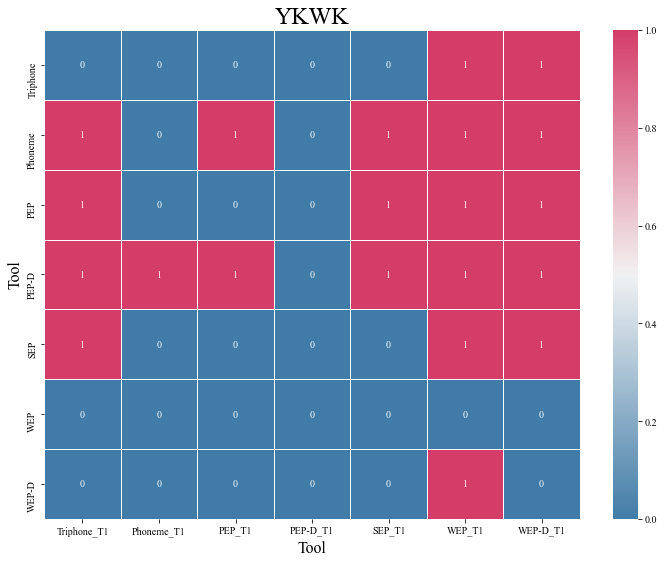

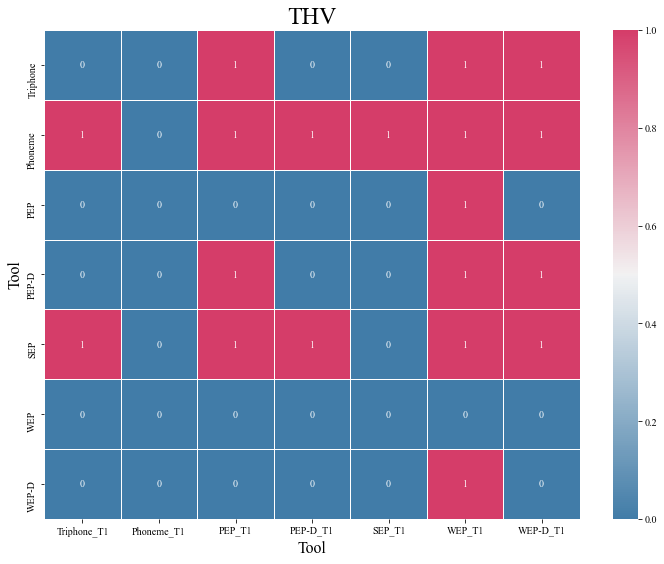

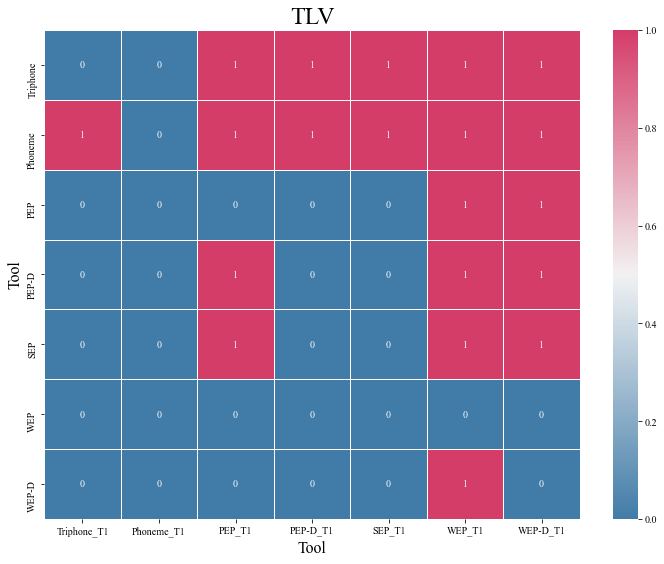

In [ ]:
values = {}

tool_short_names.remove(RANDOM)

for dataset in datasets:
    for tool_1 in tool_short_names:
        values[tool_1+"_T1"] = {}
        for tool_2 in tool_short_names:

            if tool_1 == tool_2:
                values[tool_1+"_T1"][tool_2] = 0
            else:
                arr_1 = []
                arr_2 = []
                for asr in asrs:
                    arr_1 += relative_improvement[asr][dataset][tool_1]
                    arr_2 += relative_improvement[asr][dataset][tool_2]

                w, p = scipy.stats.wilcoxon(
                    arr_1, arr_2, alternative='greater')
                # we would reject the null hypothesis at a confidence level of 5%
                if p < 0.05:
                    values[tool_1+"_T1"][tool_2] = 1
                else:
                    values[tool_1+"_T1"][tool_2] = 0


    df = pd.DataFrame(data=values)
    
    fpath = f"result/plot/RQ1/significance_difference_grouped_by_<dataset>-{dataset}.png"
    os.makedirs(os.path.dirname(fpath), exist_ok=True)


    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=240, h_pos=0, s=75, l=50, n=1, as_cmap=True)
    plot_heatmap(df, dataset, cmap, fpath, 0, 1)

tool_short_names.append(RANDOM)

                


## Analyze RQ2

In [ ]:
with open('result/RQ2.json', 'r') as f:
  data = json.load(f)


In [ ]:
res = {}
for asr in asrs:
    res[asr] = {}
    for dataset in datasets:
        res[asr][dataset] = {}
        for tool, tool_short_name in shorten_finetuned_model_name.items():
            res[asr][dataset][tool_short_name] = pd.read_csv(data[asr][dataset][tool])
            
# res


#### 2.1. Analyze the experiment without grouping

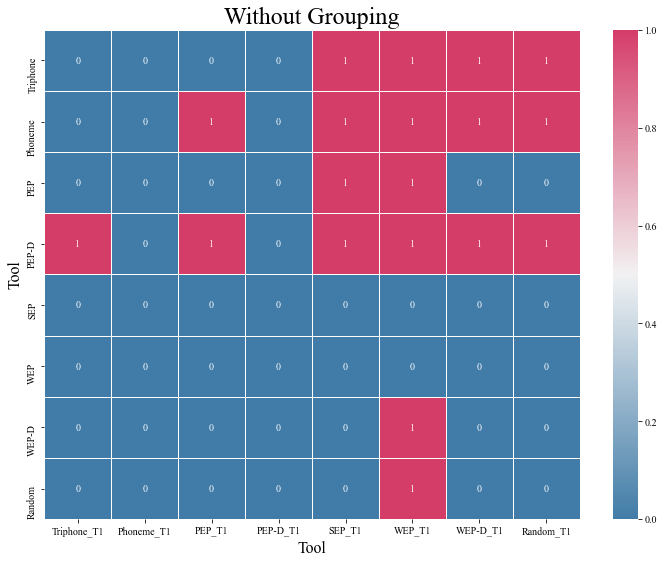

In [ ]:
values = {}
    
for tool_1 in tool_short_names:
    values[tool_1+"_T1"] = {}
    for tool_2 in tool_short_names:

        if tool_1 == tool_2:
            values[tool_1+"_T1"][tool_2] = 0
        else :
            arr_1 = []
            arr_2 = []
            for asr in asrs:
                for dataset in datasets :
                    arr_1 += get_wer_result(res[asr][dataset][tool_1])
                    arr_2 += get_wer_result(res[asr][dataset][tool_2])

            w, p = scipy.stats.wilcoxon(
                arr_1, arr_2, alternative='less')
            # we would reject the null hypothesis at a confidence level of 5%
            if p < 0.05:
                values[tool_1+"_T1"][tool_2] = 1
            else :
                values[tool_1+"_T1"][tool_2] = 0

df = pd.DataFrame(data=values)

fpath = f"result/plot/RQ2/significance_difference_without_grouping.png"
os.makedirs(os.path.dirname(fpath), exist_ok=True)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0, s=75, l=50, n=1, as_cmap=True)
plot_heatmap(df, "Without Grouping", cmap, fpath, 0, 1)
            


#### 2.2. Analyze the experiment grouped by \<Dataset\>

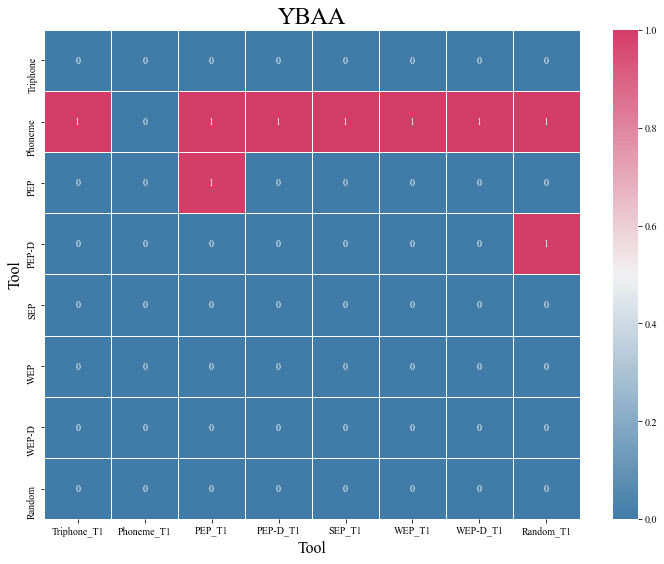

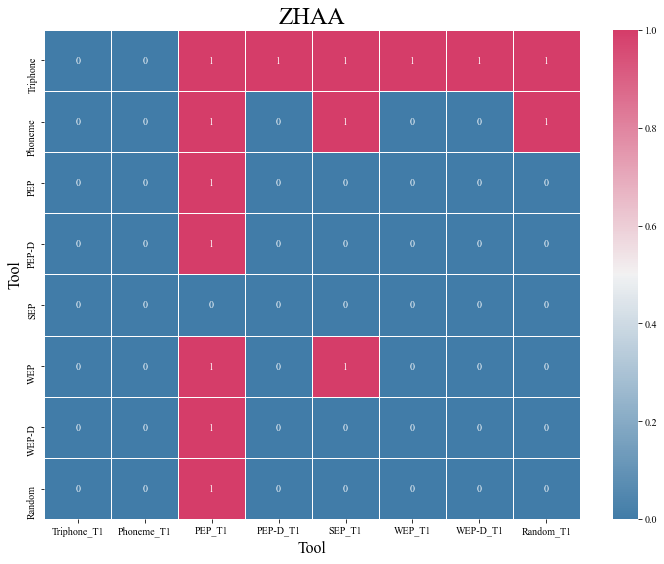

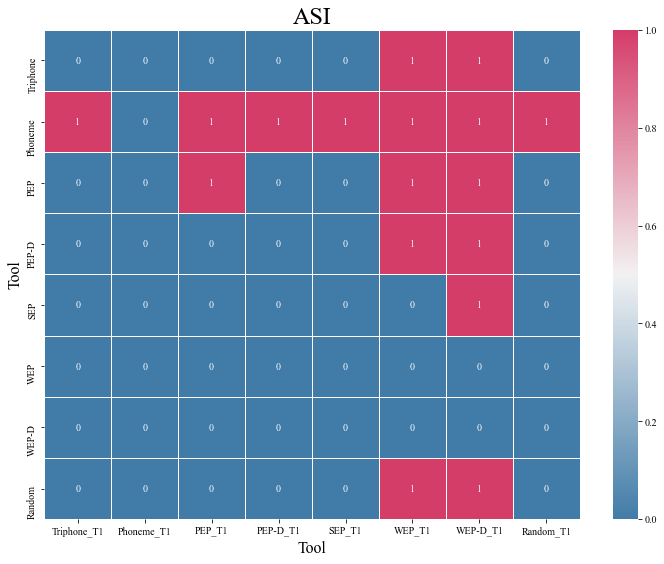

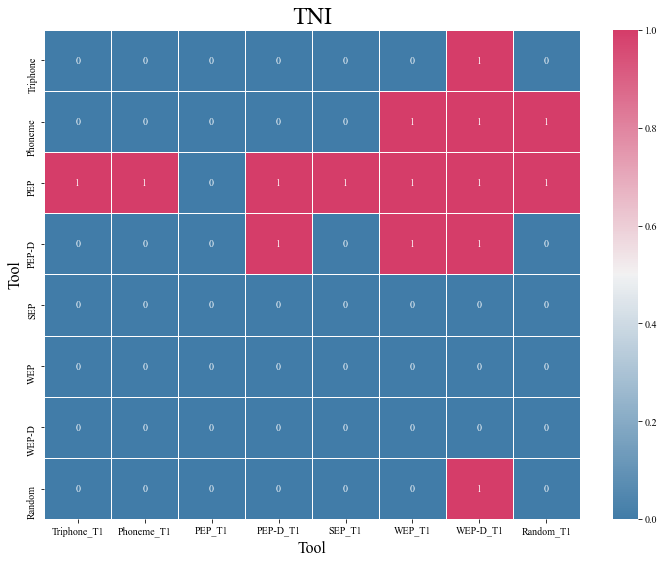

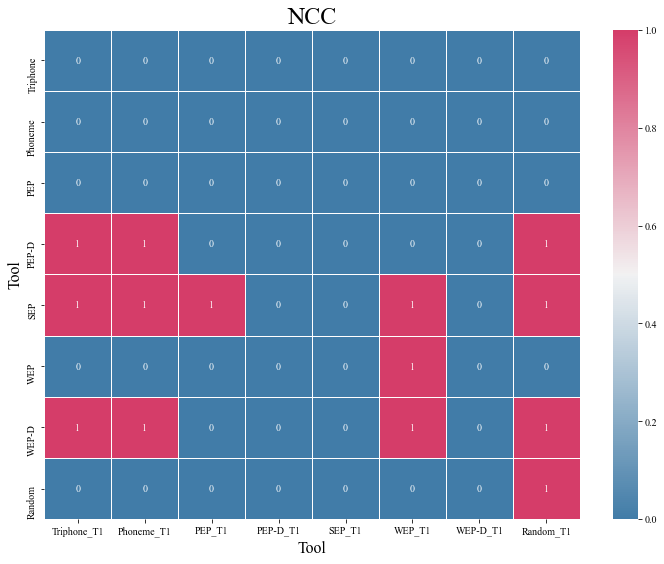

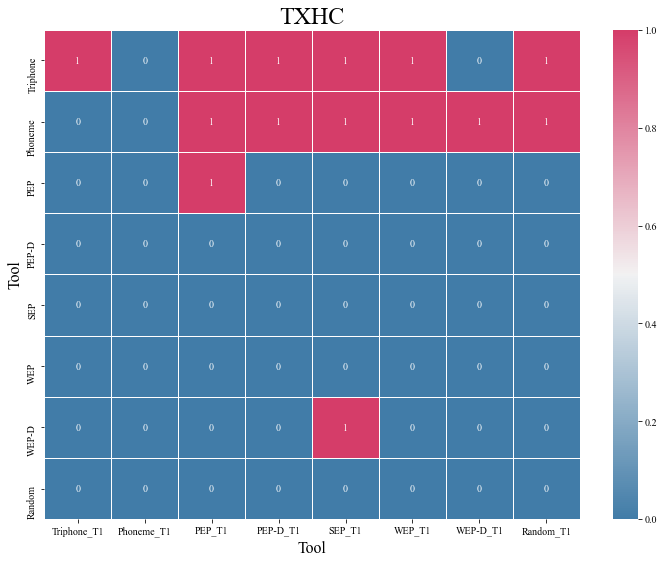

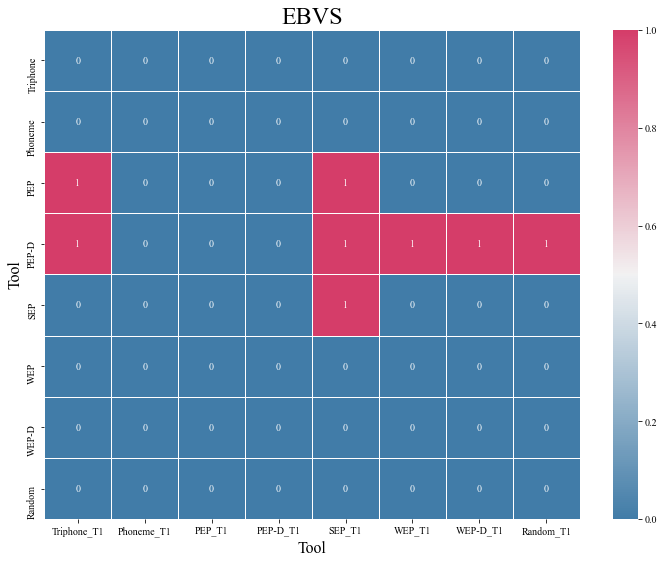

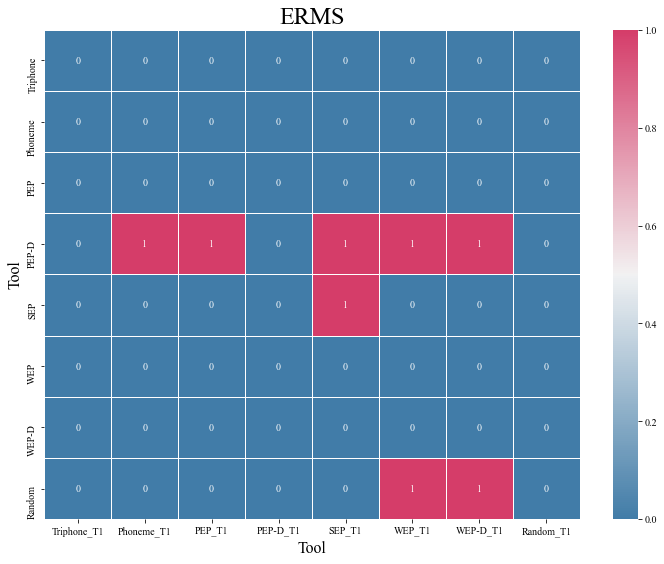

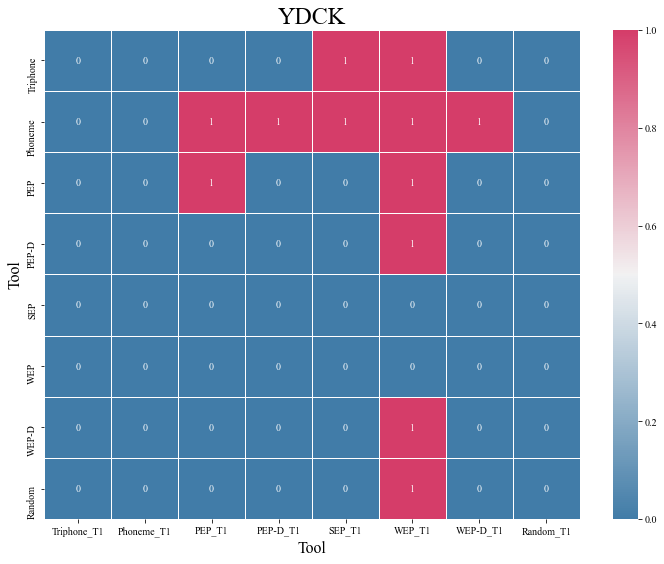

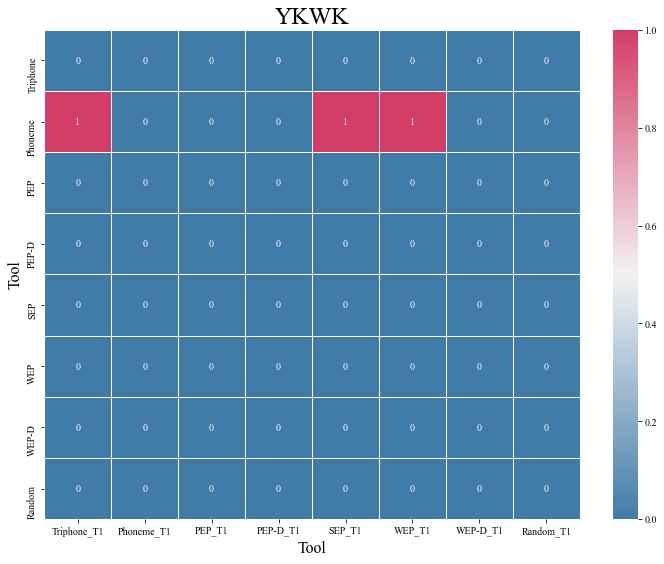

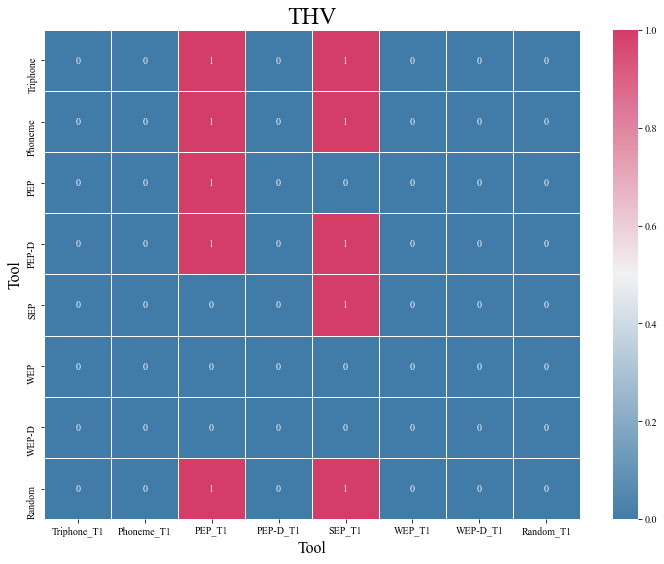

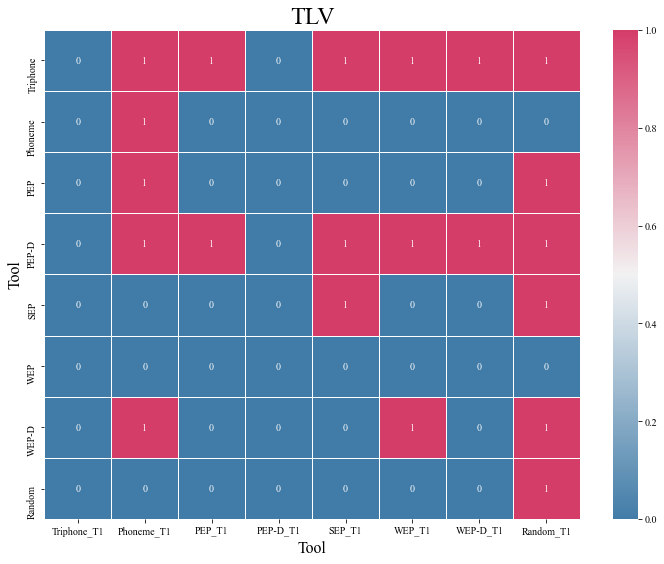

In [ ]:
values = {}
    
for dataset in datasets :
    for tool_1 in tool_short_names:
        values[tool_1+"_T1"] = {}
        for tool_2 in tool_short_names:

            if tool_1 == tool_2:
                values[tool_1+"_T1"][tool_2] = 0
            else :
                arr_1 = []
                arr_2 = []
                for asr in asrs:
                    arr_1 += get_wer_result(res[asr][dataset][tool_1])
                    arr_2 += get_wer_result(res[asr][dataset][tool_2])

            w, p = scipy.stats.wilcoxon(
                arr_1, arr_2, alternative='less')
            # we would reject the null hypothesis at a confidence level of 5%
            if p < 0.05:
                values[tool_1+"_T1"][tool_2] = 1
            else :
                values[tool_1+"_T1"][tool_2] = 0

    df = pd.DataFrame(data=values)
    
    fpath = f"result/plot/RQ2/significance_difference_grouped_by_<dataset>-{dataset}.png"
    os.makedirs(os.path.dirname(fpath), exist_ok=True)


    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=240, h_pos=0, s=75, l=50, n=1, as_cmap=True)
    plot_heatmap(df, dataset, cmap, fpath, 0, 1)
                
